In [ ]:
## Load the data to get started
import pandas as pd
import numpy as np
import tensorflow as tf
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import keras

In [ ]:
# !python -m spacy download en_core_web_md

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
data = pd.read_csv("/content/all_data.csv" )

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them 
tags = r"@\w*"


def preprocess_text(sentence, stem = True):
    sentence = tokenizer.tokenize(sentence)
    # sentence = sentence.split()

    # sentence = [re.sub(tags, "", sentence)]
    

    text = []
    # print(sentence)
    for word in sentence:
        word = word.lstrip()
        word = word.rstrip()
        word = word.replace(' ','')
        if word not in stopwords:
            
            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
                
    return tokenizer.tokenize(" ".join(text))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.review = data.review .map(preprocess_text)
data.head()

,review,sentiment
0,"[aditya, ingol, deaf]",2
1,"[i, love, app, there, issu, u, could, add, fea...",1
2,"[so, hard, use, the, web, app, fail, mobil, ap...",0
3,"[i, hate, app, make, sound, everi, time, someo...",1
4,"[useless, bse, star, mf, meet, voic, mych, slo...",0


In [ ]:
# vocabulary of words present in dataset
data_vocab = []
for text in data.review :
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)

In [ ]:
len(data_vocab)

13399

In [ ]:
data.review =data.review .apply(lambda x: " ".join(x) )

In [ ]:
data.head(2)

,review,sentiment
0,aditya ingol deaf,2
1,i love app there issu u could add featur spotl...,1


In [ ]:
max_fatures = len(data_vocab)
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['review'].values)
X = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(X)

In [ ]:
X

array([[   0,    0,    0, ..., 3310, 4623, 2492],
       [   0,    0,    0, ...,   84,   58,   18],
       [   0,    0,    0, ...,    1,  285,  143],
       ...,
       [   0,    0,    0, ...,  571,  772,   10],
       [   0,    0,    0, ...,   28,    9, 1098],
       [   0,    0,    0, ...,    1,    5,  312]], dtype=int32)

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 271, 128)          1715072   
                                                                 
 spatial_dropout1d (SpatialD  (None, 271, 128)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 100)               69000     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,790,731
Trainable params: 1,790,731
Non-trainable params: 0
______________________________________________

In [ ]:
!pip install pydot graphviz

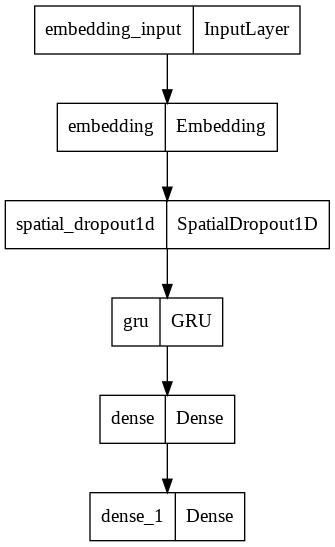

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(32414, 271) (32414, 3)
(8104, 271) (8104, 3)


In [ ]:
# Creat checkpoint to save model at the end of each epoch:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

# Creat EarlyStopping checkpoint:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(X_train, Y_train, epochs = 2 ,validation_split = 0.2 , callbacks=[checkpoint_cb, early_stopping_cb], batch_size = 64)

Epoch 1/2
406/406 [==============================] - 443s 1s/step - loss: 0.9177 - accuracy: 0.5561 - val_loss: 0.8103 - val_accuracy: 0.6310
Epoch 2/2
406/406 [==============================] - 441s 1s/step - loss: 0.7640 - accuracy: 0.6631 - val_loss: 0.7822 - val_accuracy: 0.6494


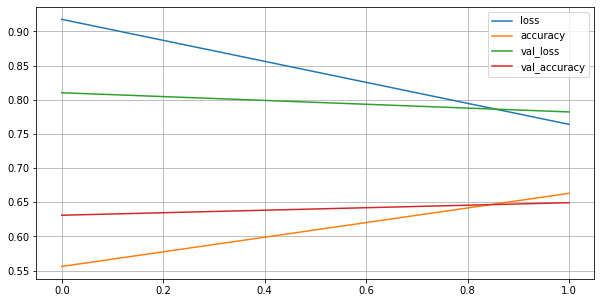

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

learning_data = pd.DataFrame(history.history)
# learning_data.head()
learning_data.plot(figsize=(10,5))
plt.grid(True)
plt.show()

In [ ]:
validation_size = 1500
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))


104/104 - 8s - loss: 0.7946 - accuracy: 0.6475 - 8s/epoch - 80ms/step
score: 0.79
acc: 0.65


Finally measuring the number of correct guesses. It is clear that finding negative reviews goes very well for the Network but deciding whether is positive is not really. My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

In [ ]:
# pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
# for x in range(len(X_validate)):
    
#     result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
#     if np.argmax(result) == np.argmax(Y_validate[x]):
#         if np.argmax(Y_validate[x]) == 0:
#             neg_correct += 1
#         else:
#             pos_correct += 1
       
#     if np.argmax(Y_validate[x]) == 0:
#         neg_cnt += 1
#     else:
#         pos_cnt += 1

In [ ]:
# print("pos_acc", pos_correct/pos_cnt*100, "%")
# print("neg_acc", neg_correct/neg_cnt*100, "%")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict(X_test) 

In [ ]:
classes_x = np.argmax(Y_pred,axis=1)

In [ ]:
classes_x

array([0, 2, 2, ..., 0, 2, 0])

In [ ]:
Y_pred

array([[0.71991205, 0.19413081, 0.08595717],
       [0.00806465, 0.04474044, 0.9471949 ],
       [0.09186377, 0.1163452 , 0.791791  ],
       ...,
       [0.8413048 , 0.13280651, 0.0258887 ],
       [0.34473917, 0.27807224, 0.37718856],
       [0.9245431 , 0.02937528, 0.04608165]], dtype=float32)

In [ ]:
Y_test

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
import numpy as np
Y_test_labels=np.argmax(Y_test, axis=1)
Y_test_labels[1]

2

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(classes_x , Y_test_labels )
cm

array([[1664,  621,  275],
       [ 290,  708,  342],
       [ 256,  544, 1904]])

In [ ]:
print(classification_report(Y_test_labels, classes_x))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70      2210
           1       0.53      0.38      0.44      1873
           2       0.70      0.76      0.73      2521

    accuracy                           0.65      6604
   macro avg       0.63      0.63      0.62      6604
weighted avg       0.64      0.65      0.64      6604

